# Fraud Detection using Unsupervised Learning

# 0. Project Objective
The goal of this project is to apply unsupervised learning, specifically anomaly detection, to identify fraudulent credit card transactions. Unlike supervised learning where models are trained on labeled data, this approach aims to find transactions that deviate significantly from the norm without prior knowledge of which transactions are fraudulent.

The primary model for this task will be the **Isolation Forest** algorithm. The core idea is that fraudulent transactions are "few and different," making them easier to isolate than normal transactions. We will analyze the patterns of these isolated anomalies to understand the characteristics of potentially fraudulent activities and propose a monitoring strategy.

In [1]:
# Importing necessary Libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
import sklearn.metrics as silhouette_score


root = '/Users/mina/Documents/GitHub/fraud_detection/'

# 1. Dataset Exploration
## 1.1 About data

The dataset contains 284,807 credit card transactions made over a period of two days. It has 31 features, which include:

* `Time`: The number of seconds elapsed between a transaction and the very first transaction in the dataset.
* `V1`-`V28`: Anonymized features that are the result of a Principal Component Analysis (PCA) transformation. This was done to protect confidential user data.
* `Amount`: The transaction amount in US dollars.
* `Class`: The target variable, where:
    * `0`: Indicates a normal transaction
    * `1`: Indicates a fraudulent transaction

For this analysis, we will use a pre-processed version of the dataset from the supervised learning task. In that task, the Time and Amount features were transformed and scaled to be on a similar footing with the anonymized V features. We will also use the original, unprocessed data to analyze the characteristics of the anomalies we detect.

## 1.2 Import data
Import both data with feature engineering without resampling and resampled data from the previous tasks for supervised learning.

In [2]:
data = pd.read_pickle('data_feature_engineering.pkl')
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,scaled_log_amount,scaled_Hours
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.135887,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-1.120133,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.698209,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.020046,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.678361,-1.996541


In [3]:
data.shape

(284807, 30)

The key point here is that we will not be using the `Class` labels to train our model. The labels will only be used at the end to evaluate how well our unsupervised model performed.

# 2. Anomaly Detection with Isolation Forest
The Isolation Forest algorithm is well-suited for this problem because it is efficient on large datasets and does not assume a specific distribution of the data. It works by building a "forest" of random trees. The core principle is that anomalies (fraudulent transactions) are easier to "isolate" in these trees, meaning they will have shorter path lengths from the root of the tree to a leaf.

We will set the `contamination` parameter to 0.01 (or 1%), which is an estimate of the proportion of anomalies in the data. This is a common practice in anomaly detection when the true proportion is unknown but expected to be small.

In [4]:
# Initialize Isolate Forest model
iso = IsolationForest(
    n_estimators=300,
    max_samples='auto',
    contamination=0.01, # assume 1% of transactions are fraud
    random_state=42,
    n_jobs=-1,
)
iso.fit(data)

IsolationForest(contamination=0.01, n_estimators=300, n_jobs=-1,
                random_state=42)

In [5]:
# Predict the anomality
iso_pred = iso.fit_predict(data)

The model has now assigned an anomaly score to each transaction. Scores below zero are considered more anomalous. Let's visualize the distribution of these scores.

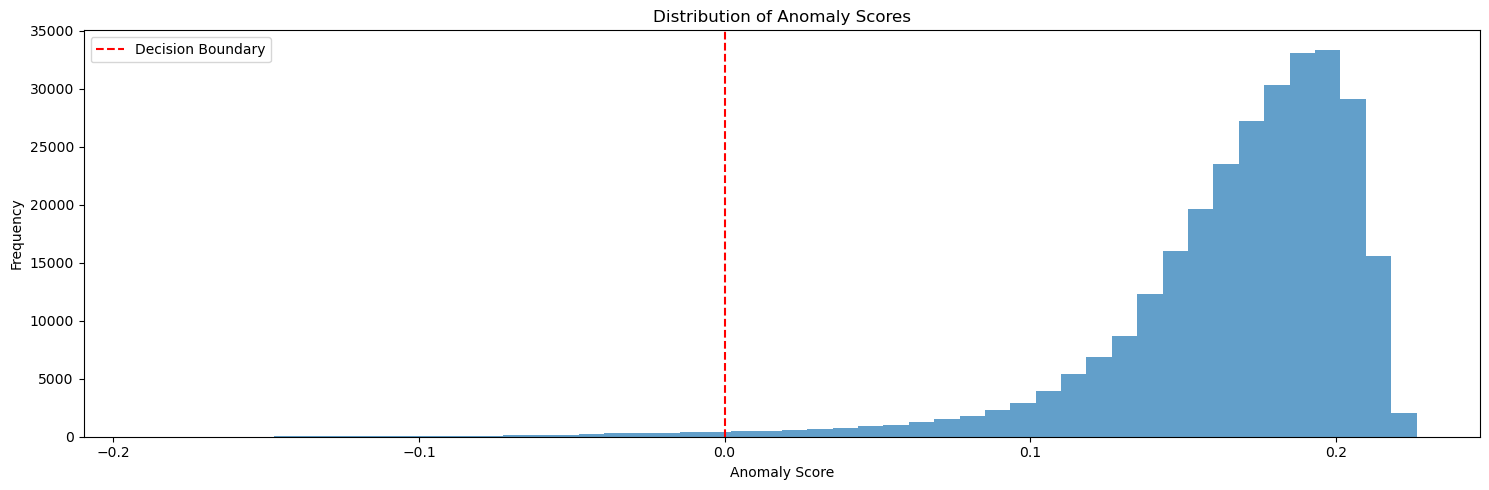

In [6]:
# Anomaly scores distribution
anomaly_scores = iso.decision_function(data)

plt.figure(figsize=(15, 5))
plt.hist(anomaly_scores, bins=50, alpha=0.7)
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Distribution of Anomaly Scores')
plt.axvline(0, color='red', linestyle='--', label='Decision Boundary')
plt.legend()
plt.tight_layout()
plt.show()

The histogram shows that most transactions have a positive anomaly score, falling into the "normal" category. A small tail of transactions with negative scores are flagged as anomalies, which aligns with our expectation that fraud is rare.

# 3. Analyzing the Detected Anomalies
Now, let's investigate the characteristics of the transactions that the Isolation Forest flagged as anomalies. We will compare their `Amount` and `Hours` distributions to those of the transactions classified as normal. This will help us understand the patterns that the model identified as suspicious.

In [7]:
# found the indices of fraud transactions
fraud_idx = np.where(iso_pred == -1)[0]
normal_idx = np.where(iso_pred != -1)[0]

In [8]:
# import original data
org_data = pd.read_csv(root + 'creditcard.csv')
org_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
org_data['Hours'] = org_data['Time'] / 3600 % 24
org_data.drop(columns=['Time', 'Class'], inplace=True)
org_data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Hours
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.000000
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.000000
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.000278
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.000278
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.000556


In [10]:
# compare feature distribution
frauds = org_data.loc[fraud_idx]
normal = org_data.loc[normal_idx]

## 3.1 Amount Distribution: Normal vs. Flagged Anomalies

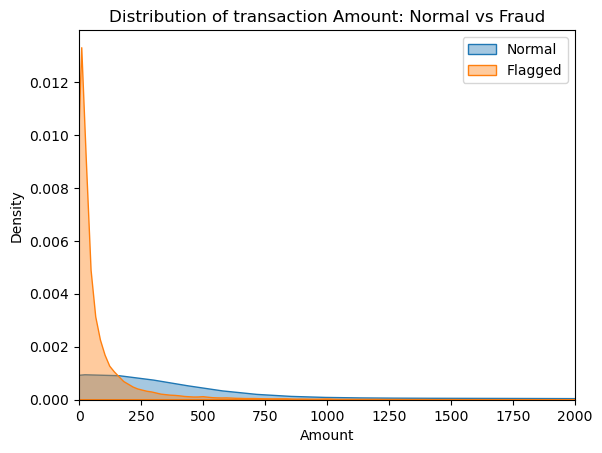

In [13]:
# compare 'Amount'
sns.kdeplot(frauds['Amount'], label="Normal", fill=True, alpha=0.4)
sns.kdeplot(normal['Amount'], label="Flagged", fill=True, alpha=0.4)
plt.title("Distribution of transaction Amount: Normal vs Fraud")
plt.xlim(0, 2000)
plt.legend()
plt.show()

# 3.2 Time Distribution: Normal vs. Flagged Anomalies

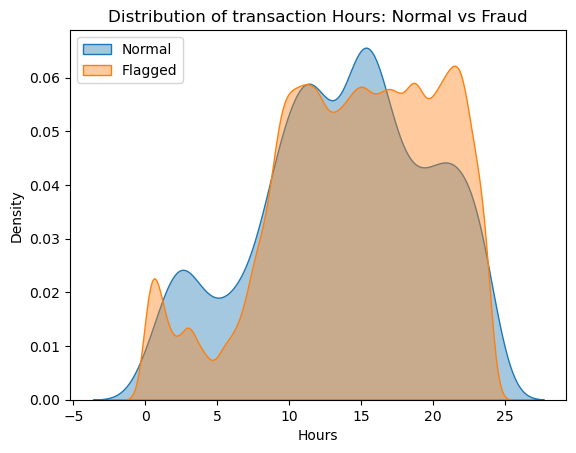

In [14]:
# compare 'Hours'
sns.kdeplot(frauds['Hours'], label="Normal", fill=True, alpha=0.4)
sns.kdeplot(normal['Hours'], label="Flagged", fill=True, alpha=0.4)
plt.title("Distribution of transaction Hours: Normal vs Fraud")
plt.legend()
plt.show()

Here, we see another distinct pattern. Normal transactions peak during typical business hours. In contrast, the flagged anomalies have a higher frequency during off-peak times, such as late evenings and early mornings. This indicates that fraudsters may be operating during these hours to reduce the chances of immediate detection.

# 4. Proposing a Monitoring Strategy
The anomaly scores provided by the Isolation Forest can be used to create a prioritized list of suspicious transactions for review. By ranking transactions from most to least anomalous, a fraud detection team can focus their efforts on the highest-risk activities.

In [18]:
# Rank transactions by anomaly score
org_data['anomaly_score'] = anomaly_scores

# Sort by anomaly score in descending order
ranked_transactions = org_data.sort_values(by='anomaly_score', ascending=False)

# Top 10 transactions with highest anomaly scores
top_10_fraud_idx = ranked_transactions[:10].index
top_10_fraud = org_data.loc[top_10_fraud_idx]

# Print the top 10 transactions
print("Top 10 transactions with highest anomaly scores:")
print(top_10_fraud[['Amount', 'Hours', 'anomaly_score']])

Top 10 transactions with highest anomaly scores:
        Amount      Hours  anomaly_score
136860   28.30  22.751389       0.226401
99693    26.70  18.677222       0.226170
122631   27.59  21.286389       0.225866
126571    3.67  21.675556       0.225719
117245   39.99  20.721944       0.225339
141743    9.99  23.465833       0.225279
83522    28.75  16.637778       0.225140
126286   16.35  21.659722       0.225013
113847   64.99  20.341111       0.224994
121867   18.92  21.208333       0.224785


The table above shows the top 10 transactions that our model deemed most anomalous. A practical strategy would be to set a daily threshold—for example, reviewing the top `k` most anomalous transactions each day.

In [19]:
k = 500 # assume 500 transactions are suspicious every day
alerts = ranked_transactions.head(k)

This proactive monitoring allows for a quick response to potentially fraudulent activities as they occur.

# 5. Conclusion
This project successfully demonstrated the use of the Isolation Forest algorithm for unsupervised fraud detection. Without relying on pre-existing labels, the model was able to identify transactions with distinct characteristics that are often associated with fraud:

* **Low transaction amounts**, possibly indicative of test charges.

* **Transactions occurring during off-peak hours**, when detection might be slower.

The anomaly scores provide a powerful tool for prioritizing investigations, allowing for a more efficient and targeted approach to fraud management. This unsupervised method is particularly valuable in real-world scenarios where labeled data may be scarce or new fraud patterns are constantly emerging.